# Etape 5 : Faites la classification supervisée via CNN Transfer Learning

Pour réaliser cette classification supervisée via CNN Transfer Learning, je partirai du dataset dont la **variable dépendante** sera notre cible `category` et nos **variables explicatives** seront les **features** extraites des images associées.  
La stratégie globale est d'extraire les features de nos images en utilisant des couches convolutives du modèle pré-entrainé **vgg-16** et de remplacer les couches denses, de classification par des couches appropriées à notre étude (détails dans le paragraphe 'Modélisation').  
Le modèle sera testé sur le dataset tel quel et ensuite avec l'ajout de données par **Data Augmentation**.

---
##### Optionnel - pour Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install keras_tuner

#####  
---

##### **Importation des librairies :**

In [79]:
# builtin libraries

from os import listdir
import os
import time

# data

import numpy as np
import pandas as pd

# viz

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# deep learning

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

# optimization

from joblib import Parallel, delayed, dump, load
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [13]:
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

Is GPU available: []


---
---
## 5.1 - Préparation données :

### 5.1.1 - Import dataset :

In [14]:
# import dataframe with images names with categories

# dataset = pd.read_csv('/content/drive/MyDrive/Projet_06/dataset_with_categories.csv') # Colab version
dataset = pd.read_csv('./data/cleaned/dataset_with_categories.csv')

In [15]:
# make a new dataframe with only images names and categories

columns = ['image', 'category']
df = dataset[columns]
df.shape

(1050, 2)

---
### 5.1.2 - Encodage de la target :

In [16]:
encoder = LabelEncoder()
true_label_encoder = encoder.fit_transform(df['category'])
df.loc[:,'encoded_category'] = true_label_encoder

---
### 5.1.3 - Préparation des images :

In [17]:
# folder path

#folder = "/content/drive/MyDrive/Projet_06/Images/" # Colab version
folder = "./data/Flipkart/Images/"

In [18]:
# make a list of every images in the folder

list_images = df.image.to_list()
print(f"There are {len(list_images)} images in the folder.")

There are 1050 images in the folder.


In [19]:
# image name example

list_images[521]

'66b75f053cb7626f49f1a9bffe77b451.jpg'

---
---
## 5.2 - Modélisation :

Approches réalisées :
* Pré-processing des images
* Création du modèle
* Entrainement modèle sans **Data augmentation**
* Entraînement modèle avec **Data augmentation**

**Data Augmentation :**  
- **Définition** : Technique pour créer de nouvelles données à partir de données existantes par des transformations.
- **Utilité** : Améliore la généralisation, réduit le surapprentissage, utile quand peu de données sont disponibles.
- **Exemples de transformations** :
  - Images : rotation, recadrage, inversion, ajout de bruit.

---
### 5.2.1 - Pré-processing des images :

Preprocessing

In [20]:
def preprocess_image(i):
    """preprocess image for vgg-16 and return an array"""

    filename = folder + list_images[i]
    loaded_img = load_img(filename, target_size=(224, 224))
    loaded_img = img_to_array(loaded_img)
    loaded_img = np.expand_dims(loaded_img, axis=0)
    loaded_img = preprocess_input(loaded_img)

    return loaded_img

In [21]:
# images pre-processing

begin = time.time()
preprocessed_array = Parallel(n_jobs=8)(
    delayed(preprocess_image)(i) for i in range(len(list_images))
)
end = time.time()

print(f"It takes {end - begin} s.")

2025-01-04 17:41:26.481560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-04 17:41:26.483589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-04 17:41:26.489700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX

It takes 3.6747279167175293 s.


In [22]:
# make array from list

preprocessed_array = np.vstack(preprocessed_array)

preprocessed_array.shape

(1050, 224, 224, 3)

---
### 5.2.2 - Split des données :

Afin d'éviter toute fuite d'information entre les jeux d'entrainement, de test et de validation, les précautions sont :
* Séparation du dataset complet en **train** et **test** avec `train_test_split` de SciKit-Learn
* Séparation du dataset **train** en **train_split** et **validation** `train_test_split` de SciKit-Learn pour la validation du **Tuner Keras**

In [82]:
# split dataset to train and test

X_train, X_test, y_train, y_test = train_test_split(preprocessed_array, df['encoded_category'], test_size=0.2, random_state=42)

In [83]:
X_train.shape

(840, 224, 224, 3)

In [84]:
y_train_one_hot = to_categorical(y_train, num_classes=7)
y_test_one_hot = to_categorical(y_test, num_classes=7)

In [85]:
# split global train dataset in train and validation datasets

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.25, random_state=42)

In [86]:
print(f"Train: {len(X_train_split)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 630, Val: 210, Test: 210


---
### 5.2.3 - Création du modèle :

**Stratégie de modèle :**  

Grâce au Tuner de Keras, recherche des hyperparamètres optimaux

* Chargement vgg-16 sans la tête de classification : `include_top=False`
* Conservation des poids pré-entraînés : `layer.trainable = False`
* Ajout d'une tête de classification adaptée à notre analyse :
    - `Pooling`
    - `Dense - activation ReLU`
    - `Dropout` afin de réduire le surapprentissage
    - `Dense(7, activation='softmax')` couche de classification
* Compilation du modèle avec un optimizer : `optimizer='adam'` [https://keras.io/api/optimizers/](https://keras.io/api/optimizers/)

In [87]:
def model_builder(hp):

    # load the pretrained VGG16 model
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

    # tune the number of layers to keep with minimum : 2
    num_conv_layers_to_keep = hp.Int('conv_layers', 
                                     min_value=2, 
                                     max_value=len(base_model.layers), 
                                     step=1
                                    )

    # create a new sequential model
    model = models.Sequential()

    # add selected convolutional layers from the base VGG16 model
    for layer in base_model.layers[:num_conv_layers_to_keep]:
        model.add(layer)

    # freeze the layers to keep them non-trainable
    for layer in model.layers:
        layer.trainable = False

    # add a pooling layer
    model.add(layers.GlobalAveragePooling2D())

    # tune the number of units in the dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    # tune the dropout rate
    hp_units_dropout = hp.Float('dropout', 
                                min_value=0.2, 
                                max_value=0.8, 
                                step=0.1
                               )
    model.add(layers.Dropout(rate=hp_units_dropout))

    # add the final dense layer for classification
    model.add(layers.Dense(7, activation='softmax'))

    # compile the model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [88]:
def model_builder(hp):

    # load the pretrained VGG16 model
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

    # tune the number of layers to keep with minimum : 2
    num_conv_layers_to_keep = hp.Int('conv_layers', 
                                     min_value=2, 
                                     max_value=len(base_model.layers), 
                                     step=1
                                    )

    # create a new sequential model
    model = models.Sequential()

    # add selected convolutional layers from the base VGG16 model
    for layer in base_model.layers[:num_conv_layers_to_keep]:
        model.add(layer)

    # freeze the layers to keep them non-trainable
    for layer in model.layers:
        layer.trainable = False

    # add a pooling layer
    model.add(layers.GlobalAveragePooling2D())

    # tune the number of units in the dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    # tune the dropout rate
    hp_units_dropout = hp.Float('dropout', 
                                min_value=0.2, 
                                max_value=0.8, 
                                step=0.1
                               )
    model.add(layers.Dropout(rate=hp_units_dropout))

    # add the final dense layer for classification
    model.add(layers.Dense(7, activation='softmax'))

    # compile the model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

---
### 5.2.4 - Entraînement sans **Data augmentation**

**Instanciation du tuner Keras :**

In [89]:
# tuner instance

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='keras_trainer',
                     project_name='kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=5, 
                                              restore_best_weights=True
                                             )

INFO:tensorflow:Reloading Tuner from keras_trainer/kt/tuner0.json


**Recherche des hyperparamètres optimaux :**

In [90]:
# search for optimal hyperparameters

tuner.search(X_train_split, 
             y_train_split,
             validation_data=(X_val, y_val),
             epochs=50, 
             callbacks=[stop_early]
            )

# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.001.



**Recherche du nombre d'epochs nécessaires pour former le modèle :**

In [91]:
# search number of epochs needed to create the model

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_split, 
                    y_train_split,
                    validation_data=(X_val, y_val),
                    epochs=50, 
                    callbacks=[stop_early]
                    )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
20/20 [==============================] - 41s 2s/step - loss: 2.6743 - accuracy: 0.5032 - val_loss: 0.8666 - val_accuracy: 0.7952
Epoch 2/50
20/20 [==============================] - 36s 2s/step - loss: 0.9226 - accuracy: 0.7810 - val_loss: 0.7917 - val_accuracy: 0.7905
Epoch 3/50
20/20 [==============================] - 49s 3s/step - loss: 0.4714 - accuracy: 0.8429 - val_loss: 0.7273 - val_accuracy: 0.8095
Epoch 4/50
20/20 [==============================] - 36s 2s/step - loss: 0.3306 - accuracy: 0.9016 - val_loss: 0.7345 - val_accuracy: 0.8143
Epoch 5/50
20/20 [==============================] - 48s 2s/step - loss: 0.1749 - accuracy: 0.9397 - val_loss: 0.7574 - val_accuracy: 0.8190
Epoch 6/50
20/20 [==============================] - 38s 2s/step - loss: 0.1376 - accuracy: 0.9540 - val_loss: 0.7404 - val_accuracy: 0.8238
Epoch 7/50
20/20 [==============================] - 39s 2s/step - loss: 0.1170 - accuracy: 0.9619 - val_loss: 0.7737 - val_accuracy: 0.8238
Epoch 8/50
20/20 [==

**Entrainement du modèle avec les hyperparamètres optimaux et le nombre d'époques nécessaires :**

In [92]:
# build hypermodel

hypermodel = tuner.hypermodel.build(best_hps)

# retrain the hypermodel
hypermodel.fit(X_train_split, 
               y_train_split, 
               validation_data=(X_val, y_val),
               epochs=best_epoch
              )

Epoch 1/8
20/20 [==============================] - 39s 2s/step - loss: 2.9227 - accuracy: 0.4873 - val_loss: 0.9608 - val_accuracy: 0.7524
Epoch 2/8
20/20 [==============================] - 36s 2s/step - loss: 0.9190 - accuracy: 0.7841 - val_loss: 0.8252 - val_accuracy: 0.8048
Epoch 3/8
20/20 [==============================] - 36s 2s/step - loss: 0.5540 - accuracy: 0.8476 - val_loss: 0.7350 - val_accuracy: 0.8000
Epoch 4/8
20/20 [==============================] - 39s 2s/step - loss: 0.3181 - accuracy: 0.8873 - val_loss: 0.7570 - val_accuracy: 0.8048
Epoch 5/8
20/20 [==============================] - 36s 2s/step - loss: 0.1761 - accuracy: 0.9444 - val_loss: 0.6920 - val_accuracy: 0.8190
Epoch 6/8
20/20 [==============================] - 40s 2s/step - loss: 0.1721 - accuracy: 0.9397 - val_loss: 0.8046 - val_accuracy: 0.8048
Epoch 7/8
20/20 [==============================] - 36s 2s/step - loss: 0.1545 - accuracy: 0.9508 - val_loss: 0.7659 - val_accuracy: 0.8190
Epoch 8/8
20/20 [==========

**Evaluation du modèle :**

In [93]:
# evaluate train

train_result = hypermodel.evaluate(X_train, y_train_one_hot)
print("[train loss, train accuracy]:", train_result)

27/27 [==============================] - 36s 1s/step - loss: 0.2019 - accuracy: 0.9548
[train loss, train accuracy]: [0.20189228653907776, 0.9547619223594666]


In [94]:
# evaluate test

eval_result = hypermodel.evaluate(X_test, y_test_one_hot)
print("[test loss, test accuracy]:", eval_result)

7/7 [==============================] - 9s 1s/step - loss: 0.7826 - accuracy: 0.8238
[test loss, test accuracy]: [0.7826021313667297, 0.8238095045089722]


**Commentaires :**  
Train : 0.972  
Test : 0.809  

Le modèle est en surapprentissage.

---
### 5.2.5 - Entraînement avec **Data augmentation**

Génération d'images supplémentaires afin d'agrandir le dataset d'entrainement :

Ajout d'images avec :
* Rotation aléatoire entre +/- 20°
* Translation horizontale gauche ou droite jusqu'à 20%
* Translation verticale haut ou bas jusqu'à 20%
* Cisaillement (déformation) de l'image avec un angle maximum de 20°
* Zoom aléatoire : agrandissement ou réduction de la taille jusqu'à 20%
* Inversion horizontale de l'image
* Remplissage des pixels vides par la valeurs de pixels voisins

In [95]:
# train generator preparation

train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.8,
        horizontal_flip=True,
        fill_mode='nearest')

# validation generator preparation without data augmentation

val_datagen = ImageDataGenerator()

In [96]:
# datasets with data augmentation

train_generator = train_datagen.flow(X_train_split, y_train_split, batch_size=64)
val_generator = val_datagen.flow(X_val, y_val, batch_size=64)

**Instanciation du tuner Keras :**

In [97]:
# instance Keras tuner

tuner_DA = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='keras_trainer_DA',
                     project_name='kt_DA2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=5, 
                                              restore_best_weights=True
                                             )

INFO:tensorflow:Reloading Tuner from keras_trainer_DA/kt_DA2/tuner0.json


**Recherche des hyperparamètres optimaux :**

In [98]:
# search hyperparameters

tuner_DA.search(train_generator,
             validation_data=val_generator,
             epochs=50,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_DA=tuner_DA.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_DA.get('units')} and the optimal learning rate for the optimizer
is {best_hps_DA.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.01.



**Recherche du nombre d'epochs nécessaires pour former le modèle :**

In [99]:
# search number of epochs needed to create the model

model_DA = tuner_DA.hypermodel.build(best_hps_DA)
history = model_DA.fit(train_generator,
                       validation_data=val_generator,
                       epochs=50,
                       callbacks=[stop_early]
                      )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
10/10 [==============================] - 39s 4s/step - loss: 7.0484 - accuracy: 0.3587 - val_loss: 2.1953 - val_accuracy: 0.7048
Epoch 2/50
10/10 [==============================] - 37s 4s/step - loss: 1.3285 - accuracy: 0.6413 - val_loss: 0.6974 - val_accuracy: 0.7667
Epoch 3/50
10/10 [==============================] - 37s 4s/step - loss: 0.9345 - accuracy: 0.6825 - val_loss: 0.6917 - val_accuracy: 0.7524
Epoch 4/50
10/10 [==============================] - 40s 4s/step - loss: 0.9050 - accuracy: 0.7238 - val_loss: 0.6053 - val_accuracy: 0.8000
Epoch 5/50
10/10 [==============================] - 38s 4s/step - loss: 0.6821 - accuracy: 0.7683 - val_loss: 0.6604 - val_accuracy: 0.8095
Epoch 6/50
10/10 [==============================] - 39s 4s/step - loss: 0.7430 - accuracy: 0.7524 - val_loss: 0.6946 - val_accuracy: 0.8048
Epoch 7/50
10/10 [==============================] - 36s 4s/step - loss: 0.6557 - accuracy: 0.7746 - val_loss: 0.6553 - val_accuracy: 0.8286
Epoch 8/50
10/10 [==

**Entrainement du modèle avec les hyperparamètres optimaux et le nombre d'époques nécessaires :**

In [100]:
# train model with best hyperparameters and epochs

hypermodel_DA = tuner_DA.hypermodel.build(best_hps_DA)

# Retrain the model
hypermodel_DA.fit(train_generator,
                  validation_data=val_generator,
                  epochs=best_epoch
                 )

Epoch 1/7
10/10 [==============================] - 39s 4s/step - loss: 5.4995 - accuracy: 0.3952 - val_loss: 1.2020 - val_accuracy: 0.7381
Epoch 2/7
10/10 [==============================] - 40s 4s/step - loss: 1.1843 - accuracy: 0.6683 - val_loss: 0.7136 - val_accuracy: 0.7762
Epoch 3/7
10/10 [==============================] - 37s 4s/step - loss: 0.8189 - accuracy: 0.7095 - val_loss: 0.6439 - val_accuracy: 0.8048
Epoch 4/7
10/10 [==============================] - 39s 4s/step - loss: 0.7325 - accuracy: 0.7492 - val_loss: 0.6834 - val_accuracy: 0.7810
Epoch 5/7
10/10 [==============================] - 37s 4s/step - loss: 0.7328 - accuracy: 0.7635 - val_loss: 0.6144 - val_accuracy: 0.7905
Epoch 6/7
10/10 [==============================] - 38s 4s/step - loss: 0.6498 - accuracy: 0.7937 - val_loss: 0.6176 - val_accuracy: 0.7952
Epoch 7/7
10/10 [==============================] - 38s 4s/step - loss: 0.5989 - accuracy: 0.8032 - val_loss: 0.7321 - val_accuracy: 0.7857


**Evaluation du modèle :**

In [101]:
# evaluate train

train_result_DA = hypermodel_DA.evaluate(X_train, y_train_one_hot)
print("[train loss, train accuracy]:", train_result_DA)

27/27 [==============================] - 36s 1s/step - loss: 0.3366 - accuracy: 0.8964
[train loss, train accuracy]: [0.33660221099853516, 0.8964285850524902]


In [102]:
# evaluate test

eval_result_DA = hypermodel_DA.evaluate(X_test, y_test_one_hot)
print("[test loss, test accuracy]:", eval_result_DA)

7/7 [==============================] - 11s 2s/step - loss: 0.8783 - accuracy: 0.8333
[test loss, test accuracy]: [0.8782837390899658, 0.8333333134651184]


**Commentaires :**  
Train : 0.838  
Test : 0.802  

Avec la Data Augmentation, on réussit à stabiliser l'apprentissage du modèle.

In [33]:
# save model

hypermodel.save('hypermodel2.keras')

In [103]:
hypermodel_DA.save('hypermodel_DA.keras')

In [104]:
model = load_model('hypermodel_DA.keras')

In [105]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [106]:
cat_list = ['category', 'encoded_category']
df_cat = df[cat_list]

In [107]:
cat = df_cat.drop_duplicates(subset=['category', 'encoded_category'])

In [108]:
cat

,category,encoded_category
0,Home Furnishing,4
1,Baby Care,0
5,Watches,6
36,Home Decor & Festive Needs,3
37,Kitchen & Dining,5
43,Beauty and Personal Care,1
47,Computers,2


In [109]:
cat_list = [
    "Baby Care",
    "Beauty and Personal Care",
    "Computers",
    "Home Decor & Festive Needs",
    "Home Furnishing",
    "Kitchen & Dining",
    "Watches"
]

In [110]:
y_test_one_hot

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [111]:
y_test = np.argmax(y_test_one_hot, axis=1)

In [112]:
y_test

array([2, 5, 2, 1, 6, 0, 3, 2, 4, 4, 6, 0, 5, 1, 2, 2, 0, 2, 4, 4, 5, 2,
       0, 2, 6, 1, 3, 5, 1, 5, 5, 2, 2, 6, 3, 4, 6, 3, 3, 2, 4, 1, 5, 4,
       1, 5, 5, 2, 0, 4, 5, 3, 5, 4, 2, 0, 1, 5, 2, 4, 4, 0, 6, 5, 6, 4,
       0, 3, 4, 6, 0, 2, 2, 2, 6, 2, 4, 3, 2, 4, 4, 4, 2, 5, 2, 6, 4, 3,
       3, 3, 4, 4, 5, 3, 6, 2, 0, 6, 3, 0, 4, 6, 3, 4, 2, 6, 1, 5, 4, 2,
       5, 4, 4, 0, 0, 0, 2, 6, 6, 2, 2, 2, 3, 4, 5, 3, 1, 3, 0, 0, 5, 1,
       0, 3, 0, 5, 3, 1, 5, 2, 5, 0, 3, 4, 4, 6, 6, 1, 3, 1, 6, 1, 6, 3,
       2, 4, 6, 1, 3, 6, 6, 6, 0, 2, 3, 6, 6, 2, 6, 2, 6, 1, 4, 6, 0, 6,
       3, 3, 4, 3, 0, 5, 4, 3, 0, 1, 0, 6, 2, 4, 1, 6, 5, 4, 5, 2, 1, 5,
       2, 2, 1, 0, 4, 2, 1, 3, 6, 0, 0, 3])

In [113]:
y_pred_one_hot = model.predict(X_test)

7/7 [==============================] - 9s 1s/step


In [114]:
y_pred = np.argmax(y_pred_one_hot, axis=1)

In [115]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=cat_list))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8333
Classification Report:
                            precision    recall  f1-score   support

                 Baby Care       0.67      0.81      0.73        27
  Beauty and Personal Care       0.70      0.90      0.79        21
                 Computers       0.92      0.92      0.92        38
Home Decor & Festive Needs       0.75      0.70      0.72        30
           Home Furnishing       0.87      0.74      0.80        35
          Kitchen & Dining       1.00      0.81      0.89        26
                   Watches       0.94      0.94      0.94        33

                  accuracy                           0.83       210
                 macro avg       0.84      0.83      0.83       210
              weighted avg       0.85      0.83      0.84       210

Confusion Matrix:
[[22  2  0  0  3  0  0]
 [ 0 19  0  1  1  0  0]
 [ 2  0 35  1  0  0  0]
 [ 3  3  1 21  0  0  2]
 [ 5  0  0  4 26  0  0]
 [ 1  2  1  1  0 21  0]
 [ 0  1  1  0  0  0 31]]


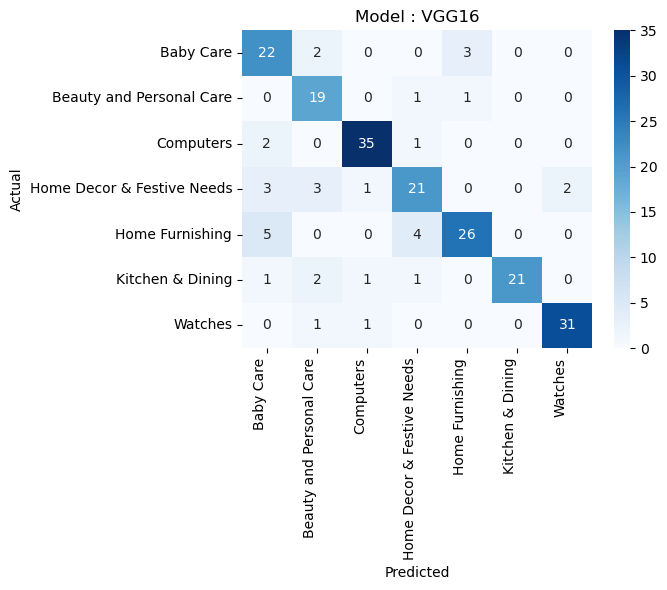

In [124]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))  
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=cat_list, yticklabels=cat_list)

plt.title("Model : VGG16")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90, ha="right")  
plt.yticks(rotation=0)  
plt.tight_layout() 
plt.savefig('matrix.png')
plt.show()

---
---
## 5.3 - Conclusion :

| Method                  | Train Loss | Train Accuracy |-| Test Loss | Test Accuracy |
|-------------------------|------------|----------------|-|-----------|---------------|
| Basic Dataset           | 0.116      | 0.972          |-| 0.776     | 0.81          |
| With Data Augmentation  | 0.59       | 0.839          |-| 0.857     | 0.802         |

Le modèle final, utilisant la **Data Augmentation**, parvient à atténuer le surapprentissage, ce qui permet une généralisation satisfaisante avec un score de précision (accuracy) modeste de 0.802 sur le jeu de données de test. Toutefois, des améliorations pourraient être envisagées avec l'intégration d'un jeu de données d'images plus conséquent. De plus, l'optimisation des hyperparamètres ou l'exploration de techniques avancées comme le fine-tuning d'un modèle pré-entraîné pourraient également contribuer à une amélioration des performances du modèle.